## MrVI

In [1]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import scanpy as sc
import scvi
import seaborn as sns
from scvi.external import MRVI

/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 8, 'svg.fonttype': 'none'})
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 8  # Colorbar tick label size
mpl.rcParams['ytick.labelsize'] = 8  # Colorbar tick label size

In [3]:
pert_type = "crispri"

In [5]:
scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
base_dir = "/burg/iicd/users/qc2358/Kinase_project/MrVi/"
save_dir = base_dir + "saved_models"
output_dir = os.path.join(base_dir, "saved_outputs", pert_type)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
figure_dir = os.path.join(base_dir, "figures", pert_type)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

[rank: 0] Global seed set to 0


Last run with scvi-tools version: 1.3.1.post1


In [38]:
dosage_colors = {
    "0": "#023047",
    "0.25": "#219EBC",
    "0.5": "#FFD166",
    "1": "#FF7F11",
}

### 1. Prepare data

In [29]:
adata_path = os.path.join(base_dir, f"filtered_gbm_{pert_type}_crop.h5ad")
adata = sc.read(adata_path)
adata

AnnData object with n_obs × n_vars = 19781 × 1768
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch'
    var: 'features'

In [30]:
adata = adata[
    (adata.obs['total_hash_umis_per_cell_ID'] > 1) & 
    (adata.obs['top_to_second_best_ratio'] > 2)].copy()

In [31]:
mapping = {1.00: '1to1', 0.50: '1to0.5', 0.25: '1to0.25', 0.00: 'Untreated'}
adata.obs['treat'] = adata.obs['dose'].replace(mapping)
adata.obs['treat']

01D_A01_RT_BC_156_Lig_BC_135-0    Untreated
01D_A01_RT_BC_97_Lig_BC_32-0           1to1
01D_B01_RT_BC_124_Lig_BC_115-0    Untreated
01D_B01_RT_BC_131_Lig_BC_85-0       1to0.25
01D_B01_RT_BC_174_Lig_BC_120-0    Untreated
                                    ...    
12D_H12_RT_BC_97_Lig_BC_157-1       1to0.25
12D_H12_RT_BC_98_Lig_BC_145-1        1to0.5
12D_H12_RT_BC_98_Lig_BC_44-1        1to0.25
12D_H12_RT_BC_98_Lig_BC_7-1          1to0.5
12D_H12_RT_BC_99_Lig_BC_86-1        1to0.25
Name: treat, Length: 15252, dtype: object

In [32]:
adata.obs['dosage'] = pd.Categorical(adata.obs['dosage'], categories=['0', '0.25', '0.5', '1'], ordered=True)

In [33]:
adata.obs['gene_id']

01D_A01_RT_BC_156_Lig_BC_135-0      NTC
01D_A01_RT_BC_97_Lig_BC_32-0        NTC
01D_B01_RT_BC_124_Lig_BC_115-0      NTC
01D_B01_RT_BC_131_Lig_BC_85-0       NTC
01D_B01_RT_BC_174_Lig_BC_120-0      NTC
                                  ...  
12D_H12_RT_BC_97_Lig_BC_157-1     ERBB4
12D_H12_RT_BC_98_Lig_BC_145-1      BRDT
12D_H12_RT_BC_98_Lig_BC_44-1      DAPK2
12D_H12_RT_BC_98_Lig_BC_7-1       STK35
12D_H12_RT_BC_99_Lig_BC_86-1       JAK1
Name: gene_id, Length: 15252, dtype: category
Categories (92, object): ['ACVR2B', 'ADCK3', 'ANKK1', 'AURKB', ..., 'TYK2', 'WNK2', 'WNK3', 'YES1']

In [34]:
adata.obs['replicate'] = adata.obs['oligo'].str.extract(r'(R[12])')
adata.obs['replicate']

01D_A01_RT_BC_156_Lig_BC_135-0    R1
01D_A01_RT_BC_97_Lig_BC_32-0      R1
01D_B01_RT_BC_124_Lig_BC_115-0    R1
01D_B01_RT_BC_131_Lig_BC_85-0     R2
01D_B01_RT_BC_174_Lig_BC_120-0    R2
                                  ..
12D_H12_RT_BC_97_Lig_BC_157-1     R2
12D_H12_RT_BC_98_Lig_BC_145-1     R2
12D_H12_RT_BC_98_Lig_BC_44-1      R1
12D_H12_RT_BC_98_Lig_BC_7-1       R2
12D_H12_RT_BC_99_Lig_BC_86-1      R2
Name: replicate, Length: 15252, dtype: object

In [35]:
adata.obs['treatment_geneid'] = adata.obs['treat'].astype(str)+ '_' + adata.obs['gene_id'].astype(str)
adata.obs['treatment_geneid']

01D_A01_RT_BC_156_Lig_BC_135-0    Untreated_NTC
01D_A01_RT_BC_97_Lig_BC_32-0           1to1_NTC
01D_B01_RT_BC_124_Lig_BC_115-0    Untreated_NTC
01D_B01_RT_BC_131_Lig_BC_85-0       1to0.25_NTC
01D_B01_RT_BC_174_Lig_BC_120-0    Untreated_NTC
                                      ...      
12D_H12_RT_BC_97_Lig_BC_157-1     1to0.25_ERBB4
12D_H12_RT_BC_98_Lig_BC_145-1       1to0.5_BRDT
12D_H12_RT_BC_98_Lig_BC_44-1      1to0.25_DAPK2
12D_H12_RT_BC_98_Lig_BC_7-1        1to0.5_STK35
12D_H12_RT_BC_99_Lig_BC_86-1       1to0.25_JAK1
Name: treatment_geneid, Length: 15252, dtype: object

### 2. Train model

In [37]:
save_path = os.path.join(save_dir, f"{pert_type}_treatment_gene_id_mrvi")
if not os.path.exists(save_path):
    sample_key = 'treatment_geneid'  # target covariate
    batch_key = "replicate"  # nuisance variable identifier
    MRVI.setup_anndata(adata, sample_key = sample_key, batch_key = batch_key)

    model = MRVI(adata)
    model.train(max_epochs = 400)
    model.save(dir_path = save_path, save_anndata = True)
else:
    model = MRVI.load(save_path, adata = adata)

/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 187 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/local/ipykernel_2007515/786852790.py:8: UserWarning: Running mrVI with Jax version larger 0.4.35 can cause performance issues
  model.train(max_epochs = 400)
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /burg/pmg/users/qc2358/mambaforge/envs/Kinase_projec ...
  rank_zero_warn(
/burg/pmg/users/qc2358/mambaforge/envs/Kinase_project/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /burg/pmg/users/qc2358/mambaforge/envs/Kinase_projec ...
  rank_zero_warn(
GPU available: False,

Epoch 400/400: 100%|██████████| 400/400 [18:38<00:00,  2.44s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.42e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [18:38<00:00,  2.80s/it, v_num=1, train_loss_step=1.28e+3, train_loss_epoch=1.42e+3]


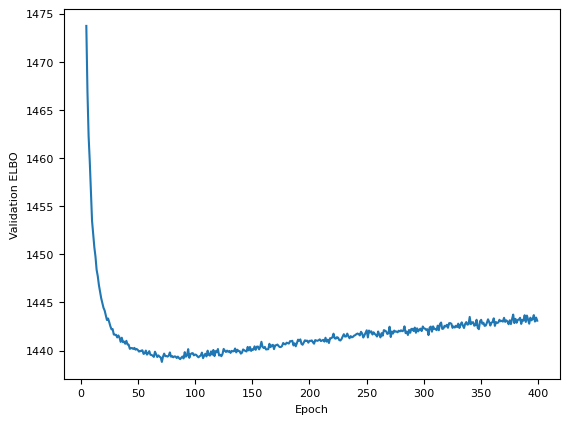

In [39]:
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

In [40]:
adata.obs.columns

Index(['P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell',
       'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID',
       'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito',
       'sgRNA', 'total_reads.y', 'sgRNA_proportion',
       'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third',
       'third_to_next', 'top_proportion', 'second_proportion',
       'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene',
       'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig',
       'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate',
       'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1',
       'UMAP2', 'PCA_Cluster', 'dosage', 'batch', 'treat', 'treatment_geneid',
       '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'],
      dtype='object')

In [41]:
model

Training status: Trained

In [50]:
u = model.get_latent_representation()
adata.obsm["mrvi_u"] = u
sc.pp.neighbors(adata, use_rep='mrvi_u', key_added="neighbors_u")
sc.tl.umap(adata, random_state=0, neighbors_key="neighbors_u", key_added="umap_u")
fig = sc.pl.embedding(adata, basis="umap_u", color=['treat'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment.pdf"), bbox_inches='tight')
plt.close(fig)
fig = sc.pl.embedding(adata, basis="umap_u", color=['gene_id'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_gene_id.pdf"), bbox_inches='tight')
plt.close(fig)
fig = sc.pl.embedding(adata, basis="umap_u", color=['treatment_geneid'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_treatment_gene_id.pdf"), bbox_inches='tight')
plt.close(fig)

100%|██████████| 120/120 [00:01<00:00, 85.99it/s] 


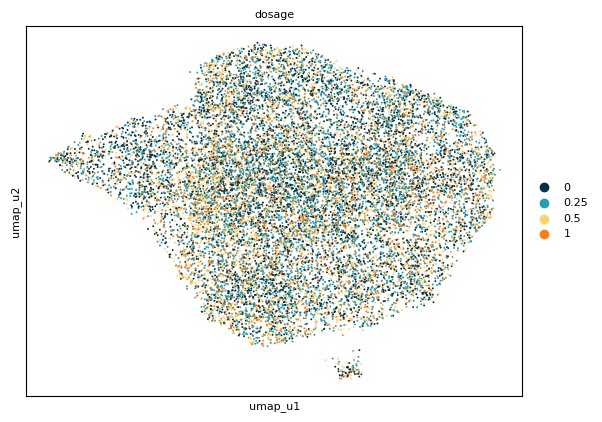

In [51]:
sc.pl.embedding(adata, basis = "umap_u", color=['dosage'])

In [52]:
# Supplementary Fig
with plt.rc_context({"figure.figsize": (4,4)}):
    fig = sc.pl.embedding(adata, basis = "umap_u", color=['dosage'],
                        palette=dosage_colors,
                        show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_dosage.png"), dpi=300, bbox_inches='tight')
plt.close(fig)

with plt.rc_context({"figure.figsize": (4,4)}):
    fig = sc.pl.embedding(adata, basis = "umap_u", color=['dosage'],
                        palette=dosage_colors,
                        show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_u_embedding_dosage.svg"), dpi=300, bbox_inches='tight')
plt.close(fig)

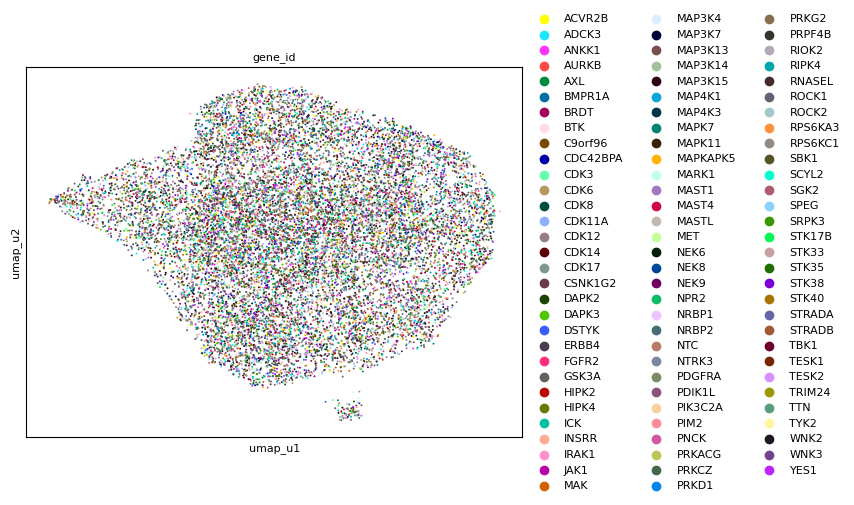

In [53]:
sc.pl.embedding(adata, basis = "umap_u", color=['gene_id'])

In [55]:
z = model.get_latent_representation(give_z=True)
adata.obsm["mrvi_z"] = z
sc.pp.neighbors(adata, use_rep='mrvi_z', key_added="neighbors_z")
sc.tl.umap(adata, random_state=0, neighbors_key="neighbors_z", key_added="umap_z")
fig = sc.pl.embedding(adata, basis = "umap_z", color=['treat'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_treatment.pdf"), bbox_inches='tight')
plt.close(fig)
fig = sc.pl.embedding(adata, basis = "umap_z", color=['gene_id'], show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_gene_id.pdf"), bbox_inches='tight')
plt.close(fig)

100%|██████████| 120/120 [00:01<00:00, 87.22it/s] 


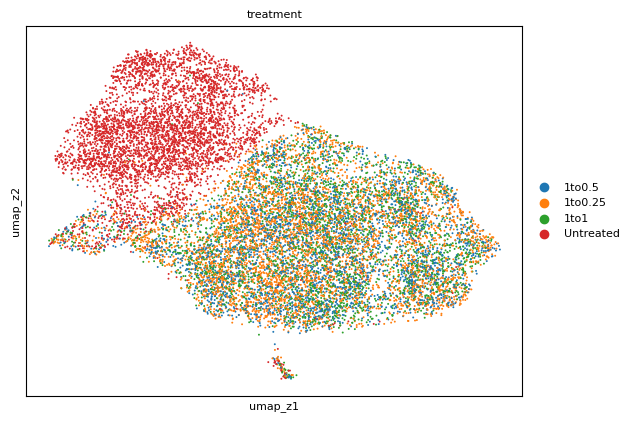

In [ ]:
sc.pl.embedding(adata, basis = "umap_z", color=['dosage'])

In [56]:
# Fig 2C
with plt.rc_context({"figure.figsize": (4,4)}):
    fig = sc.pl.embedding(adata, basis = "umap_z", color=['dosage'],
                        palette=dosage_colors,
                        show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_dosage.png"), dpi=300, bbox_inches='tight')
plt.close(fig)

with plt.rc_context({"figure.figsize": (4,4)}):
    fig = sc.pl.embedding(adata, basis = "umap_z", color=['dosage'],
                        palette=dosage_colors,
                        show=False, return_fig=True)
plt.savefig(os.path.join(figure_dir, "mrvi_z_embedding_dosage.svg"), dpi=300, bbox_inches='tight')
plt.close(fig)

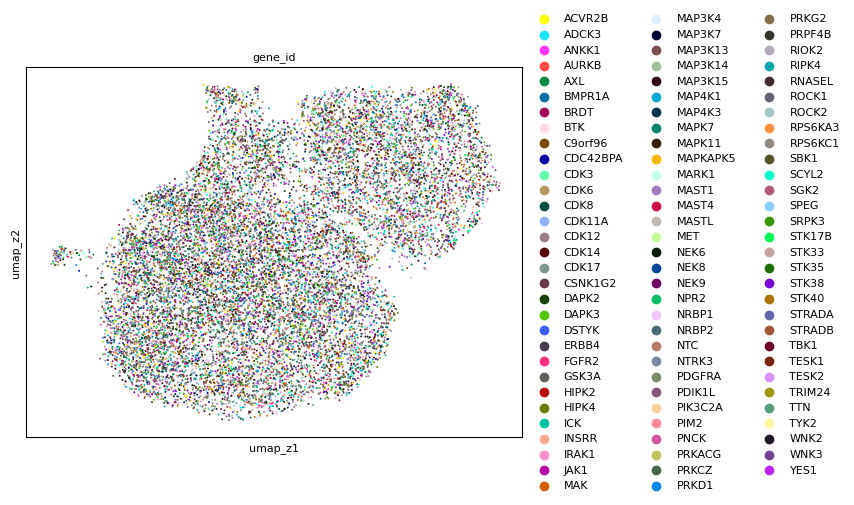

In [57]:
sc.pl.embedding(adata, basis = "umap_z", color=['gene_id'])

In [58]:
adata.write_h5ad(os.path.join(output_dir, f"mrvi_{pert_type}_adata.h5ad"))
adata

AnnData object with n_obs × n_vars = 15252 × 1768
    obs: 'P7', 'P5', 'sample', 'n.umi', 'cell_ID', 'RT', 'Lig', 'new_cell', 'oligo', 'total_reads.x', 'total_hash_umis_per_cell_ID', 'top_to_second_best_ratio', 'treatment', 'log10.umi', 'percent_mito', 'sgRNA', 'total_reads.y', 'sgRNA_proportion', 'total_sgrna_read_per_cell', 'rank', 'top_to_second', 'second_to_third', 'third_to_next', 'top_proportion', 'second_proportion', 'third_proportion', 'top_sg', 'second_sg', 'third_sg', 'gene', 'second_sg_gene', 'third_sg_gene', 'cell', 'RT_lig', 'num_genes_expressed', 'Size_Factor', 'gene_id', 'replicate', 'g1s_score', 'g2m_score', 'proliferation_index', 'dose', 'UMAP1', 'UMAP2', 'PCA_Cluster', 'dosage', 'batch', 'treat', 'treatment_geneid', '_indices', '_scvi_sample', '_scvi_batch', '_scvi_labels'
    var: 'features'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors_u', 'umap_u', 'treatment_colors', 'gene_id_colors', 'treatment_geneid_colors', 'dosage_colors', 'treat_colors', 'neighbors

### 3. Local sample stratification

In [59]:
dists_path = os.path.join(output_dir, f"{pert_type}_mrvi_treatment_geneid_dists.nc")
if not os.path.exists(dists_path):
    dists = model.get_local_sample_distances(
        keep_cell=False, groupby='treatment', batch_size=32
    )
    dists.to_netcdf(dists_path)
else:
    dists = xr.open_dataset(dists_path)

  0%|          | 0/477 [00:00<?, ?it/s]

100%|██████████| 477/477 [04:11<00:00,  1.90it/s]


In [60]:
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering
from scipy.spatial.distance import squareform

def get_dendrogram(dists):
    ds = squareform(dists)
    Z = linkage(ds, method="ward")
    Z = optimal_leaf_ordering(Z, ds)
    return Z

In [61]:
from scipy import stats
def remove_outliers(data, method='iqr', threshold=1.5):
    """
    Remove outliers from a dataset using either IQR or Z-score method
    
    Parameters:
    -----------
    data : array-like
        Input data to remove outliers from
    method : str
        'iqr' for Interquartile Range method
        'zscore' for Z-score method
    threshold : float
        For IQR method: typically 1.5 (moderate) or 3 (extreme)
        For Z-score method: typically 2 or 3 standard deviations
        
    Returns:
    --------
    cleaned_data : array-like
        Data with outliers removed
    mask : array-like
        Boolean mask where True indicates non-outlier
    """
    if method == 'iqr':
        # IQR method
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        mask = (data >= lower_bound) & (data <= upper_bound)
        
    elif method == 'zscore':
        # Z-score method
        z_scores = np.abs(stats.zscore(data))
        mask = z_scores < threshold
        
    return data[mask], mask

In [64]:
from scipy.cluster.hierarchy import fcluster
import scipy.stats as stats
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

dists_mat = dists.loc[{"treatment_name": "T-cells"}].treatment
Z = get_dendrogram(dists_mat)
sns.clustermap(
    dists_mat.to_pandas(),
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=True,
    figsize=(50, 50)
)
plt.savefig(os.path.join(figure_dir, f"mrvi_heatmap.png"), bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, f"mrvi_heatmap.svg"), bbox_inches='tight')
plt.close()

In [80]:
# Supplementary Fig: Add treatment to the heatmap
dists_df = dists_mat.to_pandas()
dists_df["dosage"] = [x.split("_")[0] for x in dists_df.index]
mapping = {'1to1': '1', '1to0.5': '0.5', '1to0.25': '0.25', 'Untreated': '0'}
dists_df["dosage"] = dists_df["dosage"].replace(mapping)
dists_df["dosage"] = pd.Categorical(dists_df["dosage"], categories=['0', '0.25', '0.5', '1'], ordered=True)

sns.clustermap(
    dists_df.drop(columns="dosage"),
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=True,
    row_colors=pd.DataFrame({"Dosage": dists_df["dosage"].map(dosage_colors)}),
    colors_ratio=0.02,
    figsize=(50, 50)
)

# Add legend for dosage colors
legend_elements = [plt.Line2D([0], [0], marker='s', color='w',
                            markerfacecolor=dosage_colors[dose],
                            markersize=10, label=dose)
                  for dose in ['0', '0.25', '0.5', '1']]

plt.legend(handles=legend_elements, title='Dosage',
          bbox_to_anchor=(3, 1), loc='upper right')
plt.savefig(os.path.join(figure_dir, f"mrvi_heatmap_dosage.png"), bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, f"mrvi_heatmap_dosage.svg"), bbox_inches='tight')
plt.close()

In [73]:
# Add cluster to the heatmap
distance_threshold = 1  # Adjust this threshold based on dendrogram inspection
clusters = fcluster(Z, distance_threshold, criterion="distance")
dists_df["Cluster"] = clusters

n_clusters = len(set(clusters))
cluster_colors = sns.color_palette("husl", n_clusters)
cluster_color_map = {i + 1: cluster_colors[i] for i in range(len(set(clusters)))}
row_cluster_colors = pd.Series(clusters, index=dists_df.index).map(cluster_color_map)
sns.clustermap(
    dists_df.drop(columns="Cluster"), # Exclude the cluster column from the heatmap
    row_linkage=Z,
    col_linkage=Z,
    xticklabels=False,
    yticklabels=True,
    row_colors=pd.DataFrame({"Cluster": row_cluster_colors}),
    figsize=(50, 50)
)
# Add legend for clusters
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', 
                            markerfacecolor=cluster_colors[i], 
                            markersize=10, label=f'Cluster {i+1}')
                    for i in range(len(set(clusters)))]

plt.legend(handles=legend_elements, title='Clusters',
            bbox_to_anchor=(3, 1), loc='upper right')
plt.savefig(os.path.join(figure_dir, f"mrvi_heatmap_cluster.png"), bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, f"mrvi_heatmap_cluster.svg"), bbox_inches='tight')
plt.close()

In [ ]:
import umap

# Convert distance matrix to UMAP embedding
umap_reducer = umap.UMAP(n_neighbors=15, metric='precomputed', random_state=0)
umap_embedding = umap_reducer.fit_transform(dists_mat)

# Create scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(umap_embedding[:,0], umap_embedding[:,1], 
            edgecolors=dists_df["dosage"].map(dosage_colors),
            s=20, facecolor='none', marker='o')
plt.savefig(os.path.join(figure_dir, f"mrvi_umap_distance.png"), bbox_inches='tight')

# Add legend for dosage colors
legend_elements = [plt.Line2D([0], [0], marker='s', color='w',
                            markeredgecolor=dosage_colors[dose],
                            markerfacecolor=None,
                            markersize=10, label=dose)
                  for dose in ['0', '0.25', '0.5', '1']]

plt.legend(handles=legend_elements, title='Dosage',
          bbox_to_anchor=(1.3, 1), loc='upper right')
plt.savefig(os.path.join(figure_dir, f"mrvi_umap_distance.png"), bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, f"mrvi_umap_distance.svg"), bbox_inches='tight')
plt.close()